In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6) #set default figure size

In [2]:
# load data
cboe_quotes = np.loadtxt('CBOEQuotes.txt')
cboe_quotes

array([[6.500e+02, 2.323e+02, 2.343e+02],
       [6.750e+02, 2.075e+02, 2.095e+02],
       [7.000e+02, 1.829e+02, 1.849e+02],
       [7.250e+02, 1.585e+02, 1.605e+02],
       [7.500e+02, 1.344e+02, 1.364e+02],
       [7.600e+02, 1.249e+02, 1.269e+02],
       [7.650e+02, 1.201e+02, 1.221e+02],
       [7.750e+02, 1.108e+02, 1.128e+02],
       [8.000e+02, 8.790e+01, 8.990e+01],
       [8.100e+02, 7.900e+01, 8.100e+01],
       [8.250e+02, 6.620e+01, 6.820e+01],
       [8.500e+02, 4.650e+01, 4.850e+01],
       [8.700e+02, 3.270e+01, 3.470e+01],
       [8.750e+02, 3.000e+01, 3.110e+01],
       [8.800e+02, 2.700e+01, 2.870e+01],
       [8.900e+02, 2.150e+01, 2.330e+01],
       [9.000e+02, 1.700e+01, 1.840e+01],
       [9.100e+02, 1.280e+01, 1.440e+01],
       [9.200e+02, 9.800e+00, 1.080e+01],
       [9.250e+02, 8.500e+00, 9.400e+00],
       [9.300e+02, 7.200e+00, 8.200e+00],
       [9.400e+02, 5.100e+00, 6.100e+00],
       [9.500e+02, 3.700e+00, 4.400e+00],
       [9.750e+02, 1.600e+00, 2.00

In [3]:
# parameters
T = 30/365 # 30 days to maturity
S0 = 884.25 # current stock price
q = 0.0176 # dividend yield
r = 0.0125 # risk-free rate
K = cboe_quotes[:,0] # strike prices
bid = cboe_quotes[:,1] # bid prices
ask = cboe_quotes[:,2] # ask prices
market = (bid + ask)/2 # mean of bid and ask prices

## Bisection Method

In [4]:
def Black_Scholes_Call(S, K, r, q, T, sigma):
    """Black-Scholes call option price.
    
    Args:
        S (float): spot price
        K (float): strike price
        r (float): risk-free interest rate
        q (float): dividend yield
        T (float): time to maturity
        sigma (float): volatility

    Returns:
        float: call option price
    """
    if sigma == 0:
        return max(S * np.exp(- q * T) - K * np.exp(- r * T), 0)
    else:
        d1 = (np.log(S/K) + (r - q + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return S * np.exp(- q * T) * norm.cdf(d1) - K * np.exp(- r * T) * norm.cdf(d2)

In [5]:
def implied_volatility_bisection(S, K, r, q, T, C, tol=1e-6, max_iter=1000):
    """Implied volatility using bisection method.

    Args:
        S (float): spot price
        K (float): strike price
        r (float): risk-free interest rate
        q (float): dividend yield
        T (float): time to maturity
        C (float): call option price
        tol (float, optional): tolerance. Defaults to 1e-6.
        max_iter (int, optional): maximum number of iterations. Defaults to 1000.

    Returns:
        _type_: approximate implied volatility
    """
    if C < S * np.exp(- q * T) - K * np.exp(- r * T):
        print("Option price $" + str(C) + " violates the arbitrage bound.")
        return np.nan
    
    lower = 0
    upper = 1
    while Black_Scholes_Call(S, K, r, q, T, upper) - C < 0:
        upper *= 2
    guess = (lower + upper) / 2
    
    while upper - lower > tol and max_iter > 0:
        diff = Black_Scholes_Call(S, K, r, q, T, guess) - C
        if diff < 0:
            lower = guess
        else:
            upper = guess
        guess = (lower + upper) / 2
        max_iter -= 1
    return guess

In [6]:
iv_bid_bisection = np.array([implied_volatility_bisection(S0, K[i], r, q, T, bid[i]) for i in range(len(K))])
iv_ask_bisection = np.array([implied_volatility_bisection(S0, K[i], r, q, T, ask[i]) for i in range(len(K))])
iv_market_bisection = np.array([implied_volatility_bisection(S0, K[i], r, q, T, market[i]) for i in range(len(K))])
iv_bisection = np.stack((iv_bid_bisection, iv_ask_bisection, iv_market_bisection), axis=1)

print(" ")
print("Implied Volatility using Bisection Method:")
print(iv_bisection)

Option price $232.3 violates the arbitrage bound.
Option price $207.5 violates the arbitrage bound.
Option price $182.9 violates the arbitrage bound.
Option price $158.5 violates the arbitrage bound.
Option price $233.3 violates the arbitrage bound.
Option price $208.5 violates the arbitrage bound.
 
Implied Volatility using Bisection Method:
[[       nan 0.5046258         nan]
 [       nan 0.46623468        nan]
 [       nan 0.43761778 0.33935022]
 [       nan 0.41029119 0.35418081]
 [0.29337454 0.38361406 0.34674215]
 [0.30126905 0.37372255 0.34213114]
 [0.29936171 0.36651659 0.33675146]
 [0.30273294 0.35829592 0.33274221]
 [0.29391813 0.33256769 0.31397581]
 [0.28782797 0.32195616 0.30536699]
 [0.27958632 0.30827475 0.29416513]
 [0.26429701 0.28714037 0.27577639]
 [0.2511878  0.27161455 0.26140928]
 [0.25202417 0.26308203 0.25755453]
 [0.24829435 0.26520681 0.25675154]
 [0.24117804 0.25903463 0.25010729]
 [0.23756075 0.2517724  0.24467325]
 [0.23021173 0.24731684 0.23879194]
 [0.228

## Newton Method

In [7]:
def vega(S, K, r, q, T, sigma):
    """Vega of a call option.
    
    Args:
        S (float): spot price
        K (float): strike price
        r (float): risk-free interest rate
        q (float): dividend yield
        T (float): time to maturity
        sigma (float): volatility

    Returns:
        float: vega
    """
    if sigma == 0:
        return 0
    else:
        d1 = (np.log(S/K) + (r - q + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
        return S * np.exp(- q * T) * norm.pdf(d1) * np.sqrt(T)

In [8]:
def implied_volatility_newton(S, K, r, q, T, C, sigma_guess=0.5, tol=1e-6, max_iter=1000):
    """Implied volatility using Newton's method.

    Args:
        S (float): spot price
        K (float): strike price
        r (float): risk-free interest rate
        q (float): dividend yield
        T (float): time to maturity
        C (float): call option price
        sigma_guess (float): initial guess of volatility
        tol (float): tolerance. Defaults to 1e-6.
        max_iter (int): maximum number of iterations. Defaults to 1000.

    Returns:
        float: approximate implied volatility
    """
    if C < S * np.exp(- q * T) - K * np.exp(- r * T):
        print("Option price $" + str(C) + " violates the arbitrage bound.")
        return np.nan
    
    sigma = sigma_guess
    while max_iter > 0:
        diff = Black_Scholes_Call(S, K, r, q, T, sigma) - C
        if abs(diff) < tol:
            break
        sigma -= diff / vega(S, K, r, q, T, sigma)
        max_iter -= 1
    return sigma

In [9]:
iv_bid_newton = np.array([implied_volatility_newton(S0, K[i], r, q, T, bid[i]) for i in range(len(K))])
iv_ask_newton = np.array([implied_volatility_newton(S0, K[i], r, q, T, ask[i]) for i in range(len(K))])
iv_market_newton = np.array([implied_volatility_newton(S0, K[i], r, q, T, market[i]) for i in range(len(K))])
iv_newton = np.stack((iv_bid_newton, iv_ask_newton, iv_market_newton), axis=1)

print(" ")
print("Implied Volatility using Newton's Method:")
print(iv_newton)

Option price $232.3 violates the arbitrage bound.
Option price $207.5 violates the arbitrage bound.
Option price $182.9 violates the arbitrage bound.
Option price $158.5 violates the arbitrage bound.
Option price $233.3 violates the arbitrage bound.
Option price $208.5 violates the arbitrage bound.
 
Implied Volatility using Newton's Method:
[[       nan 0.50462541        nan]
 [       nan 0.46623491        nan]
 [       nan 0.43761761 0.33935068]
 [       nan 0.41029135 0.35418082]
 [0.29337411 0.38361417 0.34674248]
 [0.30126863 0.37372226 0.34213076]
 [0.29936161 0.36651695 0.33675189]
 [0.3027326  0.3582963  0.33274255]
 [0.29391836 0.3325675  0.31397606]
 [0.28782754 0.32195602 0.30536718]
 [0.2795865  0.30827514 0.29416469]
 [0.2642974  0.28714062 0.27577656]
 [0.25118741 0.27161425 0.26140946]
 [0.25202431 0.2630822  0.25755428]
 [0.24829476 0.2652071  0.25675124]
 [0.24117779 0.25903427 0.2501073 ]
 [0.2375612  0.25177233 0.24467349]
 [0.23021128 0.24731676 0.2387916 ]
 [0.2288

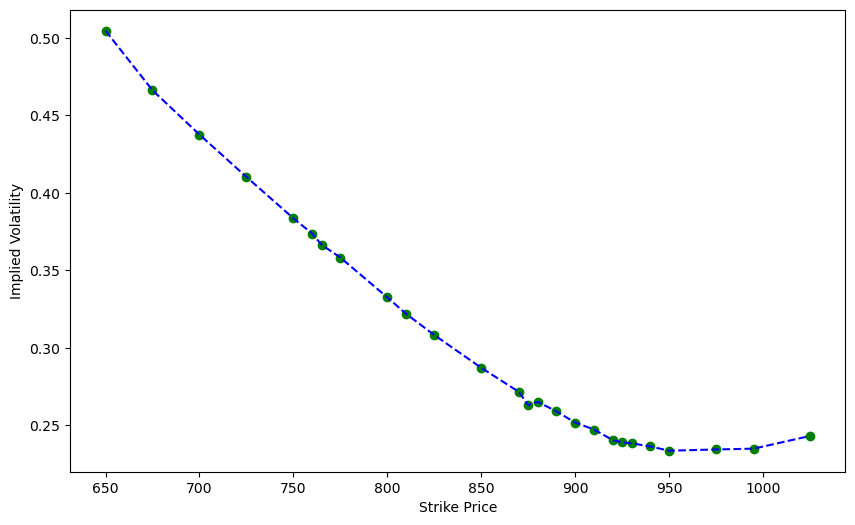

In [10]:
# Plot implied volatility
fig, ax = plt.subplots()
ax.plot(K, iv_ask_newton, 'b--', label='Implied Volatility')
ax.scatter(K, iv_ask_newton, c='g')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Implied Volatility')
plt.show()